In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import integrate
import tensorflow as tf

Hamiltonian for harmonic oscilator <br>
$H = \frac{p^2}{2m} + \frac{1}{2}kq^2$ <br>
$\dot{q} = \frac{p}{m}$<br>
$\dot{p} = kq$


In [2]:
class Oscillator:
    def __init__(self,q,k,m,dt,t_end):
        self.q = q
        self.p = 0
        self.dt = dt
        self.t_end = t_end
        self.k = k
        self.m = m
        
    # Hamiltonian system
    def f(self,t,r):
        q, p = r
        k = self.k
        m = self.m
        
        q_dot = p/m 
        p_dot = -k*q
    
        return q_dot, p_dot
    
    def solve(self):
        traj = integrate.solve_ivp(self.f,(0,t_end),(self.q,self.p),max_step = self.dt, atol = 1, method = 'RK45')
        return np.array((traj.y[0],traj.y[1],traj.t))

In [3]:
# Constants
k = 1
m = 1
dt = 0.02
t_end = 200
# IC's
q = 1

osc = Oscillator(q,k,m,dt,t_end)
traj = osc.solve() #(q,p,t)

Text(0, 0.5, 'x')

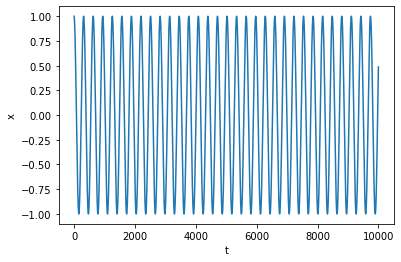

In [4]:
plt.plot(traj[0])
plt.xlabel('t'); plt.ylabel('x')

Text(0, 0.5, 'p')

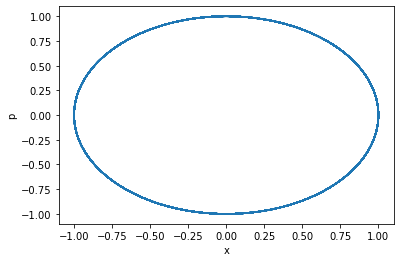

In [5]:
plt.plot(traj[0],traj[1])
plt.xlabel('x'); plt.ylabel('p')

In [29]:
# Convert data to NN format
train_size = 500
n_M = 30
train_count = 0
train_in = np.zeros((train_size,n_M+1))
train_out_q  = np.zeros((train_size))
train_out_p  = np.zeros((train_size))

for i in range(train_size): # Loop through trajectory
        init_t = int(np.floor(np.random.uniform(0,t_end/dt+1-(n_M+2))))
        # train for theta1
        train_in[train_count,:] = traj[0,init_t:init_t+n_M+1] # n-n_m to n points (ie. current n and all memories)
        train_out_q[train_count] = traj[0,init_t+n_M+1] # n+1 point
        train_out_p[train_count] = traj[1,init_t+n_M+1] # n+1 point
        
        train_count += 1

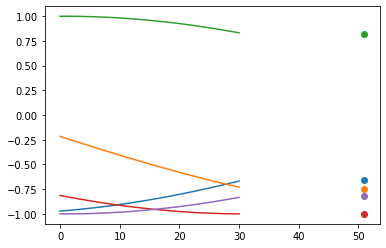

In [30]:
for i in range(0,5):
    plt.plot(train_in[i,:])
    plt.scatter(31,train_out_q[i])
plt.show()

In [43]:
# MomentumRNN
# First, let's define a momentumRNN Cell, as a layer subclass # https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN
class MomentumRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = [units,units]
        super(MomentumRNNCell, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='glorot_uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units),
                                      initializer='orthogonal',
                                      name='recurrent_kernel')
        self.built = True
        
    def call(self, inputs, states):
        stepsize = 0.02
        momentum = .99
        
        prev_h = states[0]
        prev_v = states[1]
        
        #x = (tf.keras.backend.dot(inputs, self.kernel) + self.bias) * stepsize
        x = (tf.keras.backend.dot(inputs, self.kernel)) * stepsize
        v_out =  prev_v * momentum + x
        h_out = tf.keras.activations.tanh(tf.keras.backend.dot(prev_h, self.recurrent_kernel) + v_out)
        
        return h_out, [h_out, v_out]

inputs = tf.keras.Input((n_M+1,1))

m_rnn, state_h, state_v = tf.keras.layers.RNN(MomentumRNNCell(30),return_state=True)(inputs)

outputs = tf.keras.layers.Dense(1)(m_rnn)
output_momentum = tf.keras.layers.Dense(1)(state_v)
m_rnn_model = tf.keras.Model(inputs,[outputs,output_momentum])
m_rnn_model.summary(line_length = 200)

Model: "model_12"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
input_13 (InputLayer)                                             [(None, 31, 1)]                             0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
rnn_12 (RNN)                                                      [(None, 30), (None, 30), (None, 30)]        930                     input_13[0][0]                              

In [44]:
inputs = tf.keras.Input((n_M+1,1))
m_rnn = tf.keras.layers.RNN(MomentumRNNCell(30))(inputs)
outputs = tf.keras.layers.Dense(1)(m_rnn)
m_rnn_model_2 = tf.keras.Model(inputs,outputs)
m_rnn_model_2.summary(line_length = 200)

Model: "model_13"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                                              Output Shape                                                                    Param #                       
input_14 (InputLayer)                                                                     [(None, 31, 1)]                                                                 0                             
________________________________________________________________________________________________________________________________________________________________________________________________________
rnn_13 (RNN)                                                                              (None, 30)                                                                      930     

In [45]:
inputs = tf.keras.Input((n_M+1,1))
m_rnn = tf.keras.layers.RNN(tf.keras.layers.SimpleRNNCell(30))(inputs)
outputs = tf.keras.layers.Dense(1)(m_rnn)
m_rnn_model_3 = tf.keras.Model(inputs,outputs)
m_rnn_model_3.summary(line_length = 200)

Model: "model_14"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                                              Output Shape                                                                    Param #                       
input_15 (InputLayer)                                                                     [(None, 31, 1)]                                                                 0                             
________________________________________________________________________________________________________________________________________________________________________________________________________
rnn_14 (RNN)                                                                              (None, 30)                                                                      960     

In [46]:
inputs = tf.keras.Input((n_M+1,1))
m_rnn = tf.keras.layers.RNN(tf.keras.layers.LSTMCell(30))(inputs)
outputs = tf.keras.layers.Dense(1)(m_rnn)
m_rnn_model_4 = tf.keras.Model(inputs,outputs)
m_rnn_model_4.summary(line_length = 200)

Model: "model_15"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                                              Output Shape                                                                    Param #                       
input_16 (InputLayer)                                                                     [(None, 31, 1)]                                                                 0                             
________________________________________________________________________________________________________________________________________________________________________________________________________
rnn_15 (RNN)                                                                              (None, 30)                                                                      3840    

In [47]:
train_in = np.reshape(train_in,(train_in.shape[0],n_M+1,1))
train_out_q = np.reshape(train_out_q,(train_in.shape[0],1,1))
train_out_p = np.reshape(train_out_p,(train_in.shape[0],1,1))

In [48]:
tf.random.set_seed(0)
optimizer = tf.keras.optimizers.Adam(lr = .001)
m_rnn_model.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model.fit(train_in.astype('float32'),[train_out_q.astype('float32'),train_out_p.astype('float32')],epochs=20,batch_size=10,shuffle=True,verbose=0)

optimizer = tf.keras.optimizers.Adam(lr = .0001)
m_rnn_model.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model.fit(train_in.astype('float32'),[train_out_q.astype('float32'),train_out_p.astype('float32')],epochs=20,batch_size=10,shuffle=True,verbose=0)

optimizer = tf.keras.optimizers.Adam(lr = .00001)
m_rnn_model.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model.fit(train_in.astype('float32'),[train_out_q.astype('float32'),train_out_p.astype('float32')],epochs=20,batch_size=10,shuffle=True,verbose=0)

In [49]:
tf.random.set_seed(0)
optimizer = tf.keras.optimizers.Adam(lr = .001)
m_rnn_model_2.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model_2.fit(train_in.astype('float32'),train_out_q.astype('float32'),epochs=20,batch_size=10,shuffle=True,verbose=0)

optimizer = tf.keras.optimizers.Adam(lr = .0001)
m_rnn_model_2.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model_2.fit(train_in.astype('float32'),train_out_q.astype('float32'),epochs=20,batch_size=10,shuffle=True,verbose=0)

optimizer = tf.keras.optimizers.Adam(lr = .00001)
m_rnn_model_2.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model_2.fit(train_in.astype('float32'),train_out_q.astype('float32'),epochs=20,batch_size=10,shuffle=True,verbose=0)

In [50]:
tf.random.set_seed(0)
optimizer = tf.keras.optimizers.Adam(lr = .001)
m_rnn_model_3.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model_3.fit(train_in.astype('float32'),train_out_q.astype('float32'),epochs=20,batch_size=10,shuffle=True,verbose=0)

optimizer = tf.keras.optimizers.Adam(lr = .0001)
m_rnn_model_3.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model_3.fit(train_in.astype('float32'),train_out_q.astype('float32'),epochs=20,batch_size=10,shuffle=True,verbose=0)

optimizer = tf.keras.optimizers.Adam(lr = .00001)
m_rnn_model_3.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model_3.fit(train_in.astype('float32'),train_out_q.astype('float32'),epochs=20,batch_size=10,shuffle=True,verbose=0)

In [51]:
tf.random.set_seed(0)
optimizer = tf.keras.optimizers.Adam(lr = .001)
m_rnn_model_4.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model_4.fit(train_in.astype('float32'),train_out_q.astype('float32'),epochs=20,batch_size=10,shuffle=True,verbose=0)

optimizer = tf.keras.optimizers.Adam(lr = .0001)
m_rnn_model_4.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model_4.fit(train_in.astype('float32'),train_out_q.astype('float32'),epochs=20,batch_size=10,shuffle=True,verbose=0)

optimizer = tf.keras.optimizers.Adam(lr = .00001)
m_rnn_model_4.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model_4.fit(train_in.astype('float32'),train_out_q.astype('float32'),epochs=20,batch_size=10,shuffle=True,verbose=0)

In [52]:
length = 1000 #1000
S = np.zeros((1,length+2,2))
S[0,0:n_M+1,0] = traj[0,0:n_M+1]
t = traj[2,0:length+2]
for i in range(length+3-(n_M+2)): # 0 to 20 by 0.02 in time
    S[0,i+n_M+1,:] = m_rnn_model.predict(np.reshape(S[0,i:i+n_M+1,0],(1,n_M+1,1)))
    
S_2 = np.zeros((1,length+2))
S_2[0,0:n_M+1] = traj[0,0:n_M+1]
for i in range(length+3-(n_M+2)): # 0 to 20 by 0.02 in time
    S_2[0,i+n_M+1] = m_rnn_model_2.predict(np.reshape(S_2[0,i:i+n_M+1],(1,n_M+1,1)))
    
S_3 = np.zeros((1,length+2))
S_3[0,0:n_M+1] = traj[0,0:n_M+1]
for i in range(length+3-(n_M+2)): # 0 to 20 by 0.02 in time
    S_3[0,i+n_M+1] = m_rnn_model_3.predict(np.reshape(S_3[0,i:i+n_M+1],(1,n_M+1,1)))
    
S_4 = np.zeros((1,length+2))
S_4[0,0:n_M+1] = traj[0,0:n_M+1]
for i in range(length+3-(n_M+2)): # 0 to 20 by 0.02 in time
    S_4[0,i+n_M+1] = m_rnn_model_4.predict(np.reshape(S_4[0,i:i+n_M+1],(1,n_M+1,1)))

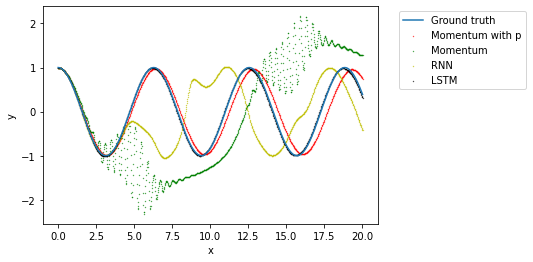

MSE Momentum with p:
3.15e-02
MSE Momentum:
1.78e+00
MSE RNN:
8.65e-01
MSE LSTM:
1.93e-03


In [53]:
plt.plot(traj[2,0:length+2],traj[0,0:length+2])
plt.scatter(traj[2,0:length+2],S[0,:,0],c='r',s=.1)
plt.scatter(traj[2,0:length+2],S_2[0,:],c='g',s=.1)
plt.scatter(traj[2,0:length+2],S_3[0,:],c='y',s=.1)
plt.scatter(traj[2,0:length+2],S_4[0,:],c='k',s=.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Ground truth','Momentum with p','Momentum','RNN','LSTM'],bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.title('Momentum RNN')
plt.show()
MSE = np.mean(np.square(traj[0,0:length+2] - S[0,:,0]))
print('MSE Momentum with p:')
print('{:.2e}'.format(MSE))
MSE = np.mean(np.square(traj[0,0:length+2] - S_2[0,:]))
print('MSE Momentum:')
print('{:.2e}'.format(MSE))
MSE = np.mean(np.square(traj[0,0:length+2] - S_3[0,:]))
print('MSE RNN:')
print('{:.2e}'.format(MSE))
MSE = np.mean(np.square(traj[0,0:length+2] - S_4[0,:]))
print('MSE LSTM:')
print('{:.2e}'.format(MSE))

Text(0, 0.5, 'p')

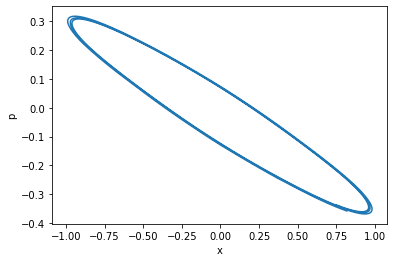

In [54]:
plt.plot(S[0,n_M+1:,0],S[0,n_M+1:,1])
plt.xlabel('x')
plt.ylabel('p')